## Import Keras Dependencies

In [1]:
from __future__ import print_function
import collections
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
import argparse

Using TensorFlow backend.


In [2]:
from keras import layers, initializers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, LSTM, ConvLSTM2D
from keras.layers.core import Reshape
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3859048910469991920
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1580543464608164162
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


## Get Data

In [4]:
import os
import sys
sys.path.append("/home/ubuntu/anaconda3/lib/python3.6/site-packages")
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as intp
import sys
import time
from matplotlib import animation, rc
from matplotlib.pyplot import figure
import hdf5storage as h5mat
import h5py as h5
import sklearn.model_selection
import pydot
from matplotlib.pyplot import figure

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [5]:
# directory info
model_directory = '/home/ubuntu/CS230_project/velocitynn/data/layers/models/'
model_file = '600x200x10000_flat2.mat'
model_path = model_directory+model_file
shot_directory = '/home/ubuntu/CS230_project/velocitynn/data/layers/shots/'
shot_file = '600x200x10000_flat2_1shot.mat'
shot_path=shot_directory+shot_file
filepath=os.getcwd()

In [6]:
# Reading all the shot data
dout = h5.File(shot_path,'r')

# Reading all the velocity models
dout1 = h5.File(model_path,'r')

depth_sample = 10
vel_top = 1500
time_max = 0.8
time_sample = 2e-3
time_interp = np.arange(depth_sample/vel_top, time_max,time_sample)

num_shots = 1000
shot_shape_offset,shot_shape_time  = dout['shot_model_1'].shape
shot_data =  np.zeros((shot_shape_offset,shot_shape_time,num_shots)) #offset, time, samples
vel_rms_data = np.zeros((time_interp.shape[0],num_shots))

for i in range(num_shots):
    shot_data[:,:,i] = dout['shot_model_'+str(i)]
    vp_dummy = dout1['vp'+str(i)]
    vp_dummy = np.transpose(vp_dummy[:,:])
    vp_trace = vp_dummy[:,int(vp_dummy.shape[1]/2)]
    time_diff = depth_sample/vp_trace
    time = np.cumsum(time_diff)
    vp = intp.interp1d(time, vp_trace)(time_interp)
    vel_rms_data[:,i] = np.sqrt(np.cumsum(vp**2)/np.arange(1,vp.shape[0]+1,1))
    
del dout, dout1, vp_dummy, vp_trace, time, vp

print('n_x:',shot_data.shape)
print('n_y:', vel_rms_data.shape)

n_x: (599, 433, 1000)
n_y: (397, 1000)


In [7]:
# Normalize input and output data
shot_data_normalize = (shot_data - np.min(shot_data, axis =(0,1)))/(np.max(shot_data, axis =(0,1))-np.min(shot_data, axis =(0,1)))
vel_rms_data_normalize = (vel_rms_data - np.min(vel_rms_data, axis=0))/(np.max(vel_rms_data, axis=0) - np.min(vel_rms_data, axis=0))

# Reshape
vel_rms_data_normalize = vel_rms_data_normalize.transpose()
shot_data_normalize = np.swapaxes(shot_data_normalize.transpose(),1,2 )

# Split data into train and test set
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(shot_data_normalize,vel_rms_data_normalize, test_size=0.2, random_state=1)

# X_test, X_val, Y_test, Y_val = sklearn.model_selection.train_test_split(X_test, Y_test, test_size=0.5, random_state=1)

# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
# X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 800
number of test examples = 200
X_train shape: (800, 599, 433, 1)
Y_train shape: (800, 397)
X_test shape: (200, 599, 433, 1)
Y_test shape: (200, 397)


## Implement ConvLSTM

In [8]:
# Building neural network in Keras 
given_seed = 3 # For repeatibility

def velocitynet(input_shape):
    """
    Implementation of the VelocityNet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input
    X_input= Input(input_shape)
    X=X_input
   
    # CONV -> BN -> RELU Block applied to X
    
    X = Conv2D(16, (14, 14), strides=(2, 2), name='conv0', 
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    


    # MAXPOOL
    X = MaxPooling2D((2, 2), strides=(2,2),name='max_pool0')(X)
    X = Dropout(0.3)(X)
    

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Reshape((146,105*16))(X)
    
    X=LSTM(397)(X)
    
    X = Dense(397, activation='sigmoid', name='fc')(X)
    X = Activation('relu')(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    
    model = Model(inputs=X_input, outputs=X, name='velModel')

    return model
    ### END CODE HERE ###

In [9]:
# Create the model

velModel = velocitynet(X_train.shape[1:])

In [10]:
velModel.summary()


plot_model(velModel)
SVG(model_to_dot(velModel).create(prog='dot', format='svg'))
plot_model(velModel, to_file='./Figures/model_plot_Abhishek_LSTM_CONV.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 599, 433, 1)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 293, 210, 16)      3152      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 293, 210, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 293, 210, 16)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 146, 105, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 146, 105, 16)      0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 146, 1680)         0         
__________

In [11]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [12]:
# Compile the model with optimization algorithm, loss function
# from keras.utils import multi_gpu_model
# velModel = multi_gpu_model(velModel, gpus=1)
from keras import optimizers
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

velModel.compile(loss='mean_squared_error', metrics=['accuracy', 'mse'], optimizer = adam)

In [13]:
history = velModel.fit(X_train, Y_train, validation_split=0.1, epochs=500, batch_size=32)

Train on 720 samples, validate on 80 samples
Epoch 1/500
720/720 [==============================] - 18s 25ms/step - loss: 0.0249 - acc: 0.0000e+00 - mean_squared_error: 0.0249 - val_loss: 0.0070 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0070
Epoch 2/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0069 - acc: 0.6667 - mean_squared_error: 0.0069 - val_loss: 0.0068 - val_acc: 0.1500 - val_mean_squared_error: 0.0068
Epoch 3/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0054 - acc: 0.6153 - mean_squared_error: 0.0054 - val_loss: 0.0094 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0094
Epoch 4/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0048 - acc: 0.1361 - mean_squared_error: 0.0048 - val_loss: 0.0104 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0104
Epoch 5/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0038 - acc: 0.2319 - mean_squared_error: 0.0038 - val_loss: 0.0125 - val

720/720 [==============================] - 14s 19ms/step - loss: 0.0012 - acc: 0.9639 - mean_squared_error: 0.0012 - val_loss: 0.0206 - val_acc: 0.8500 - val_mean_squared_error: 0.0206
Epoch 83/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0011 - acc: 0.9597 - mean_squared_error: 0.0011 - val_loss: 0.0222 - val_acc: 0.9000 - val_mean_squared_error: 0.0222
Epoch 84/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0010 - acc: 0.9667 - mean_squared_error: 0.0010 - val_loss: 0.0274 - val_acc: 0.8750 - val_mean_squared_error: 0.0274
Epoch 85/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0010 - acc: 0.9681 - mean_squared_error: 0.0010 - val_loss: 0.0307 - val_acc: 0.9000 - val_mean_squared_error: 0.0307
Epoch 86/500
720/720 [==============================] - 14s 19ms/step - loss: 0.0010 - acc: 0.9694 - mean_squared_error: 0.0010 - val_loss: 0.0295 - val_acc: 0.9000 - val_mean_squared_error: 0.0295
Epoch 87/500
720/720 [=

720/720 [==============================] - 14s 19ms/step - loss: 7.8284e-04 - acc: 0.9736 - mean_squared_error: 7.8284e-04 - val_loss: 0.0372 - val_acc: 0.9375 - val_mean_squared_error: 0.0372
Epoch 123/500
720/720 [==============================] - 14s 19ms/step - loss: 7.5903e-04 - acc: 0.9736 - mean_squared_error: 7.5903e-04 - val_loss: 0.0398 - val_acc: 0.9375 - val_mean_squared_error: 0.0398
Epoch 124/500
720/720 [==============================] - 14s 19ms/step - loss: 7.0506e-04 - acc: 0.9736 - mean_squared_error: 7.0506e-04 - val_loss: 0.0379 - val_acc: 0.9250 - val_mean_squared_error: 0.0379
Epoch 125/500
720/720 [==============================] - 14s 19ms/step - loss: 6.9806e-04 - acc: 0.9736 - mean_squared_error: 6.9806e-04 - val_loss: 0.0348 - val_acc: 0.9125 - val_mean_squared_error: 0.0348
Epoch 126/500
720/720 [==============================] - 14s 19ms/step - loss: 7.1716e-04 - acc: 0.9736 - mean_squared_error: 7.1716e-04 - val_loss: 0.0326 - val_acc: 0.9375 - val_mean_s

Epoch 162/500
720/720 [==============================] - 14s 19ms/step - loss: 6.6540e-04 - acc: 0.9736 - mean_squared_error: 6.6540e-04 - val_loss: 0.0365 - val_acc: 0.9375 - val_mean_squared_error: 0.0365
Epoch 163/500
720/720 [==============================] - 14s 19ms/step - loss: 6.5882e-04 - acc: 0.9736 - mean_squared_error: 6.5882e-04 - val_loss: 0.0300 - val_acc: 0.9375 - val_mean_squared_error: 0.0300
Epoch 164/500
720/720 [==============================] - 14s 19ms/step - loss: 5.6708e-04 - acc: 0.9736 - mean_squared_error: 5.6708e-04 - val_loss: 0.0289 - val_acc: 0.9375 - val_mean_squared_error: 0.0289
Epoch 165/500
720/720 [==============================] - 14s 19ms/step - loss: 5.8344e-04 - acc: 0.9736 - mean_squared_error: 5.8344e-04 - val_loss: 0.0333 - val_acc: 0.9375 - val_mean_squared_error: 0.0333
Epoch 166/500
720/720 [==============================] - 14s 19ms/step - loss: 5.8072e-04 - acc: 0.9736 - mean_squared_error: 5.8072e-04 - val_loss: 0.0379 - val_acc: 0.937

Epoch 241/500
720/720 [==============================] - 14s 19ms/step - loss: 4.2200e-04 - acc: 0.9736 - mean_squared_error: 4.2200e-04 - val_loss: 0.0312 - val_acc: 0.9375 - val_mean_squared_error: 0.0312
Epoch 242/500
720/720 [==============================] - 14s 19ms/step - loss: 4.5240e-04 - acc: 0.9736 - mean_squared_error: 4.5240e-04 - val_loss: 0.0316 - val_acc: 0.9375 - val_mean_squared_error: 0.0316
Epoch 243/500
720/720 [==============================] - 14s 19ms/step - loss: 4.5568e-04 - acc: 0.9736 - mean_squared_error: 4.5568e-04 - val_loss: 0.0316 - val_acc: 0.9375 - val_mean_squared_error: 0.0316
Epoch 244/500
720/720 [==============================] - 14s 19ms/step - loss: 4.6701e-04 - acc: 0.9736 - mean_squared_error: 4.6701e-04 - val_loss: 0.0239 - val_acc: 0.9375 - val_mean_squared_error: 0.0239
Epoch 245/500
720/720 [==============================] - 14s 19ms/step - loss: 4.3042e-04 - acc: 0.9736 - mean_squared_error: 4.3042e-04 - val_loss: 0.0232 - val_acc: 0.937

Epoch 320/500
720/720 [==============================] - 14s 19ms/step - loss: 3.6089e-04 - acc: 0.9736 - mean_squared_error: 3.6089e-04 - val_loss: 0.0292 - val_acc: 0.9375 - val_mean_squared_error: 0.0292
Epoch 321/500
720/720 [==============================] - 14s 19ms/step - loss: 3.6103e-04 - acc: 0.9736 - mean_squared_error: 3.6103e-04 - val_loss: 0.0310 - val_acc: 0.9375 - val_mean_squared_error: 0.0310
Epoch 322/500
720/720 [==============================] - 14s 19ms/step - loss: 3.6697e-04 - acc: 0.9736 - mean_squared_error: 3.6697e-04 - val_loss: 0.0308 - val_acc: 0.9375 - val_mean_squared_error: 0.0308
Epoch 323/500
720/720 [==============================] - 14s 19ms/step - loss: 3.5925e-04 - acc: 0.9736 - mean_squared_error: 3.5925e-04 - val_loss: 0.0228 - val_acc: 0.9375 - val_mean_squared_error: 0.0228
Epoch 324/500
720/720 [==============================] - 14s 19ms/step - loss: 3.5178e-04 - acc: 0.9736 - mean_squared_error: 3.5178e-04 - val_loss: 0.0216 - val_acc: 0.937

Epoch 399/500
720/720 [==============================] - 14s 19ms/step - loss: 3.6088e-04 - acc: 0.9736 - mean_squared_error: 3.6088e-04 - val_loss: 0.0320 - val_acc: 0.9375 - val_mean_squared_error: 0.0320
Epoch 400/500
720/720 [==============================] - 14s 19ms/step - loss: 3.2910e-04 - acc: 0.9736 - mean_squared_error: 3.2910e-04 - val_loss: 0.0252 - val_acc: 0.9375 - val_mean_squared_error: 0.0252
Epoch 401/500
720/720 [==============================] - 14s 19ms/step - loss: 3.0902e-04 - acc: 0.9736 - mean_squared_error: 3.0902e-04 - val_loss: 0.0216 - val_acc: 0.9375 - val_mean_squared_error: 0.0216
Epoch 402/500
720/720 [==============================] - 14s 19ms/step - loss: 3.4829e-04 - acc: 0.9736 - mean_squared_error: 3.4829e-04 - val_loss: 0.0247 - val_acc: 0.9375 - val_mean_squared_error: 0.0247
Epoch 403/500
720/720 [==============================] - 14s 19ms/step - loss: 3.1860e-04 - acc: 0.9736 - mean_squared_error: 3.1860e-04 - val_loss: 0.0314 - val_acc: 0.937

Epoch 478/500
720/720 [==============================] - 14s 19ms/step - loss: 2.7773e-04 - acc: 0.9736 - mean_squared_error: 2.7773e-04 - val_loss: 0.0038 - val_acc: 0.9375 - val_mean_squared_error: 0.0038
Epoch 479/500
720/720 [==============================] - 14s 19ms/step - loss: 2.7175e-04 - acc: 0.9736 - mean_squared_error: 2.7175e-04 - val_loss: 0.0068 - val_acc: 0.9375 - val_mean_squared_error: 0.0068
Epoch 480/500
720/720 [==============================] - 14s 19ms/step - loss: 2.6870e-04 - acc: 0.9736 - mean_squared_error: 2.6870e-04 - val_loss: 0.0070 - val_acc: 0.9375 - val_mean_squared_error: 0.0070
Epoch 481/500
720/720 [==============================] - 14s 19ms/step - loss: 2.9308e-04 - acc: 0.9736 - mean_squared_error: 2.9308e-04 - val_loss: 0.0042 - val_acc: 0.9375 - val_mean_squared_error: 0.0042
Epoch 482/500
720/720 [==============================] - 14s 19ms/step - loss: 2.6898e-04 - acc: 0.9736 - mean_squared_error: 2.6898e-04 - val_loss: 0.0073 - val_acc: 0.937

In [14]:
# Testing and evaluating the model
preds = velModel.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

200/200 [==============================] - 2s 9ms/step

Loss = 0.0030421591363847256
Test Accuracy = 0.97


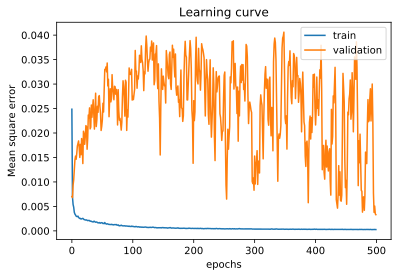

In [15]:
# Plotting the learning curve 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('Mean square error')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
# plt.savefig('/Figures/learning_curve_LSTM.png', bbox_inches='tight')

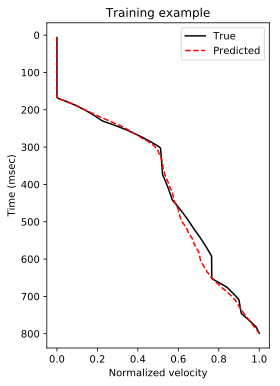

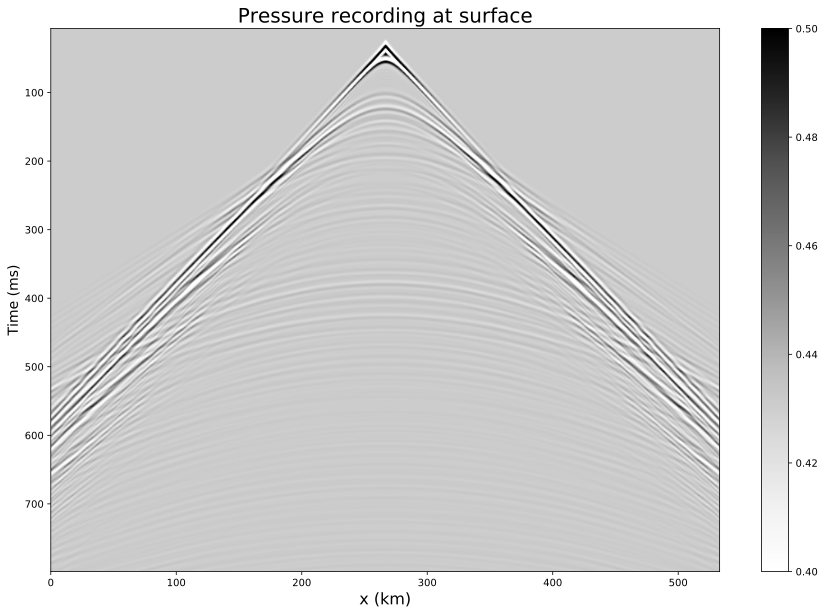

In [17]:
# Plot some of the training examples - true vs trained
sample_number = 30
X_train_sample = X_train[sample_number,:,:,:]
X_train_sample = np.expand_dims(X_train_sample, axis=0)
Y_train_sample = Y_train[sample_number,:]
Y_train_sample_predict = velModel.predict(X_train_sample)

figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
line1, = plt.plot(Y_train_sample, time_interp*1e3, '-k')
line2, = plt.plot(Y_train_sample_predict[0,:], time_interp*1e3, '--r')
plt.legend((line1, line2), ('True', 'Predicted'))
plt.xlabel('Normalized velocity')
plt.ylabel('Time (msec)')
plt.title('Training example')
plt.gca().invert_yaxis()
# plt.savefig('./Figures/training_example_velocity_08Dec.png', bbox_inches='tight')
plt.show()

# clip=0.65;
p_el = np.reshape(X_train[sample_number,:,:,:], (599,433)).transpose()
# vmin=np.min(p_el)*clip;
# vmax=np.max(p_el)*clip;
# fig, ax = plt.subplots(figsize=(10,10))
figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=0.4, 
               vmax=0.5, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper', extent=[0,533,np.max(time_interp)*1e3,np.min(time_interp)*1e3])
plt.title('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.colorbar()
plt.show()
# plt.savefig('./Figures/training_example_seismic_08Dec.png', bbox_inches='tight')

In [1]:
# Plot some of test examples
sample_number = 10 # 4, 40, 15, 25, 33
X_test_sample = X_test[sample_number,:,:,:]
X_test_sample = np.expand_dims(X_test_sample, axis=0)
Y_test_sample = Y_test[sample_number,:]
Y_test_sample_predict = velModel.predict(X_test_sample)

figure(num=None, figsize=(4, 6), dpi=80, facecolor='w', edgecolor='k')
line1, =plt.plot(Y_test_sample, time_interp*1e3, '-k')
line2, = plt.plot(Y_test_sample_predict[0,:], time_interp*1e3, '--r')
plt.legend((line1, line2), ('True', 'Predicted'))
plt.title('Test example')
plt.xlabel('Normalized velocity')
plt.ylabel('Time (sec)')
plt.gca().invert_yaxis()
# plt.savefig('Figures/test_example_velocity_08Dec_1.png', bbox_inches='tight')
plt.show()

# clip=0.65;
p_el = np.reshape(X_test[sample_number,:,:,:], (599,433)).transpose()
# vmin=np.min(p_el)*clip;
# vmax=np.max(p_el)*clip;
# fig, ax = plt.subplots(figsize=(10,10))
figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(p_el[:,:], 
               interpolation='bilinear', 
               vmin=0.4, 
               vmax=0.5, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper', extent=[0,533,np.max(time_interp)*1e3,np.min(time_interp)*1e3])
plt.title('Pressure recording at surface', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.colorbar()
plt.show()
# plt.savefig('Figures/test_example_seismic_08Dec_1.png', bbox_inches='tight')

NameError: name 'X_test' is not defined